# 沒有使用G@C回收設施的原因的demographics，比如：選擇[不想麻煩]的受訪者的[年齡層]分佈

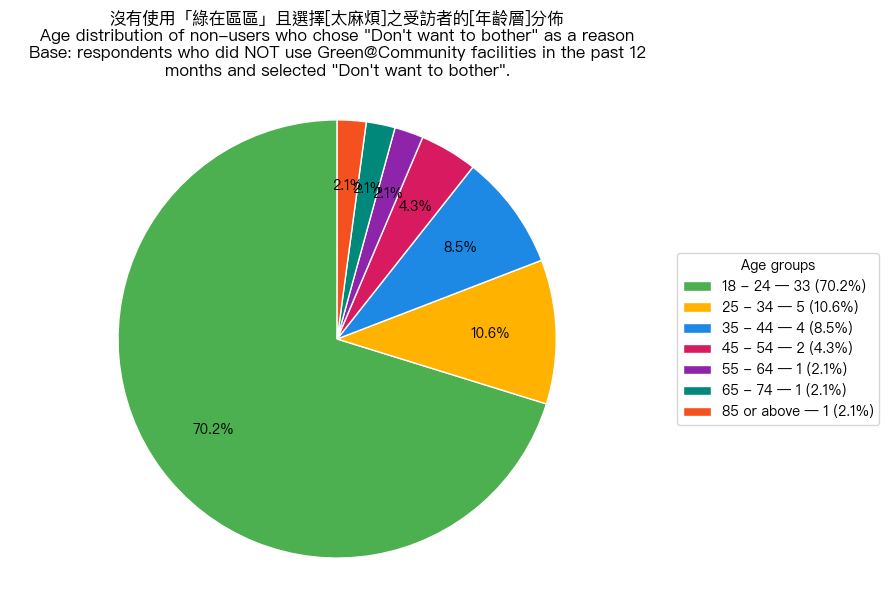

In [6]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("openpyxl")
_ensure("matplotlib")
_ensure("numpy")

# ---------- imports ----------
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from textwrap import wrap

# ---------- load data ----------
data_path = Path("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- helper to find columns ----------
def find_col(columns, patterns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    for c, norm in cols:
        if any(re.search(p, norm, flags=re.IGNORECASE) for p in patterns):
            return c
    return None

# Column: used G@C in past 12 months (Yes / No)
use_patterns = [
    r"in\s+the\s+past\s+12\s+months.*used\s+any\s+green@community\s+recycling\s+facility",
    r"在最近12個月.*有否使用過.*綠在區區.*回收設施",
]
use_col = find_col(df.columns, use_patterns)
if use_col is None:
    raise RuntimeError("Could not find the 'In the past 12 months, have you used any G@C facility?' column.")

# Column: reasons for NOT using G@C
reasons_patterns = [
    r"what\s+are\s+the\s+reasons\s+you\s+did\s+not\s+use\s+green@community\s+facilities\s+in\s+the\s+past\s+12\s+months",
    r"在過去12個月.*沒有使用.*綠在區區.*原因",
]
reasons_col = find_col(df.columns, reasons_patterns)
if reasons_col is None:
    raise RuntimeError("Could not find the 'reasons did not use G@C in past 12 months' column.")

# Column: Age
age_patterns = [r"\bage\b", r"年齡"]
age_col = find_col(df.columns, age_patterns)
if age_col is None:
    raise RuntimeError("Could not find the Age column.")

use_series     = df[use_col].astype(str)
reasons_series = df[reasons_col].fillna("").astype(str)
age_series     = df[age_col].astype(str)

# ---------- build masks ----------
# Non-users only (answered "No" to using G@C in past 12 months)
def is_no_use(v):
    s = str(v).strip().lower()
    return s in {"no", "n", "否", "沒有", "未有", "無"}

mask_non_user = use_series.map(is_no_use)

# Among non-users, those whose reasons include "Don't want to bother"
# ("too troublesome" in the questionnaire; cleaned-data wording prevails)
mask_too_trouble = reasons_series.str.contains("Don't want to bother", case=False, regex=False)

# Combined mask
mask_target = mask_non_user & mask_too_trouble

ages_target = age_series[mask_target].dropna().str.strip()

# ---------- count age groups ----------
age_order_pref = [
    "17 or below",
    "18 - 24",
    "25 - 34",
    "35 - 44",
    "45 - 54",
    "55 - 64",
    "65 - 74",
    "75 - 84",
    "85 or above",
]

counts_raw = ages_target.value_counts()
ordered_labels = [a for a in age_order_pref if a in counts_raw.index] + \
                 [a for a in counts_raw.index if a not in age_order_pref]

counts = [int(counts_raw.get(a, 0)) for a in ordered_labels]
total  = sum(counts)

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK",
                  "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = font_name
        break
plt.rcParams["axes.unicode_minus"] = False

# ---------- legend labels ----------
pct = [(c / total * 100) if total > 0 else 0.0 for c in counts]
legend_labels = [
    f"{ordered_labels[i]} — {counts[i]} ({pct[i]:.1f}%)"
    for i in range(len(ordered_labels))
]

# ---------- plot pie chart (white background, legend on right) ----------
fig, ax = plt.subplots(figsize=(9, 6), facecolor="white")
ax.set_facecolor("white")

# use a colourful palette (Tab20) for clearer differences
base_colors = [
    "#4CAF50",  # green
    "#FFB300",  # amber/gold
    "#1E88E5",  # blue
    "#D81B60",  # magenta
    "#8E24AA",  # purple
    "#00897B",  # teal
    "#F4511E",  # orange-red (in case there are more slices)
    "#6D4C41",  # brown
]


wedges, text_labels, autotexts = ax.pie(
    counts,
    labels=None,  # use legend instead
    colors=base_colors[:len(counts)],
    startangle=90,
    autopct=(lambda p: f"{p:.1f}%") if total > 0 else None,
    pctdistance=0.7,
    wedgeprops=dict(edgecolor="white"),
)

ax.legend(
    wedges,
    legend_labels,
    title="Age groups",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0.0,
)

title_main = "沒有使用「綠在區區」且選擇[太麻煩]之受訪者的[年齡層]分佈\n" \
             "Age distribution of non-users who chose \"Don't want to bother\" as a reason"
title_sub  = "Base: respondents who did NOT use Green@Community facilities in the past 12 months and selected \"Don't want to bother\"."
wrapped_sub = "\n".join(wrap(title_sub, 80))

ax.set_title(title_main + "\n" + wrapped_sub, pad=16)

ax.axis("equal")  # keep pie circular
plt.tight_layout()
plt.show()
